In [2]:
import pandas as pd
import numpy as np
import os
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline
from surprise import SVD
from surprise.dataset import Reader, Dataset
from surprise.model_selection import GridSearchCV

In [3]:
pwd

'/Users/MartinJohnsen/Documents/Martin Johnsen/MMC/3. Semester/Advanced Business Analytics/Project/Business_Analytics_Olist/phase2'

## Recommender systems 

#### Collaborative filtering 

Collaborative recommenders rely on data generated by users as they interact with items. 

Benefits 

- it is always “self-generating” — users create the data for you naturally as they interact with items. This can be a valuable data source, especially in cases where high-quality item features are not available or difficult to obtain. 
- Another benefit of collaborative filters is that it helps users discover new items that are outside the subspace defined by their historical profile.

Drawbacks 

- the well-known cold start problem. 
- It is also difficult for collaborative filters to accurately recommend novel or niche items because these items typically do not have enough user-item interaction data.

**Item-item** (http://www.diva-portal.org/smash/get/diva2:1111865/FULLTEXT01.pdf):

Item based collaborative filtering was introduced 1998 by Amazon[6]. Unlike user based collaborative filtering, item based filtering looks at the similarity between different items, and does this by taking note of how many users that bought item X also bought item Y. If the correlation is high enough, a similarity can be presumed to exist between the two items, and they can be assumed to be similar to one another. Item Y will from there on be recommended to users who bought item X and vice versa.

In item-item collaborative filtering, we provide a recommendation based on other items similar to ours. The **benefits** of it, compared to user-user collaborative filtering, is that we usually need much fewer similarity computations (in most cases, there are much more users in systems than items). The most **common pitfall** - the system can provide very obvious recommendations.

**User-user** (http://www.diva-portal.org/smash/get/diva2:1111865/FULLTEXT01.pdf):

The report is focusing on the “nearest neighbour” approach for recommendations, which looks at the users rating patterns and finds the “nearest neighbours”, i.e users with ratings similar to yours. The algorithm then proceeds to give you recommendations based on the ratings of these neighbours.

In user-user collaborative filtering, we provide a recommendation based on tastes of other users similar to us. **The problem** with that algorithm is that we need a lot of information about other people to provide correct recommendations, but the main benefits are effectiveness and ability to provide new, unexpected, and, yet, good recommendations.

### Content recommenders

Content recommenders rely on item features to make recommendations. 

Benefits

- Content filters tend to be more robust against popularity bias and the cold start problem. 
- They can easily recommend new or novel items based on niche tastes. 

Drawbacks

- However, in an item-to-item recommender, content filters can only recommend items with features similar to the original item. 
- This limits the scope of recommendations, and can also result in surfacing items with low ratings.

##### In this project

Given our dataset and the features we have, we are not able to create a content-based filtering algorithm, as the algorithm would need more information. We would essentially need to know some specific attributes about every product, e.g. with movies we know whether they include themes such as: Baseball, Economics, etc. 
Furthermore, companies such as Amazon are using collaborative item-item based recommender systems (https://www.quora.com/What-algorithm-s-does-Amazon-use-in-their-recommendation-system), and this is also the one that makes most sense in our case, since we do not have a lot of information of about each individual (we do not have many purchases from each person). 



In [4]:
df_reviews = pd.read_csv("../data/olist_order_reviews_dataset.csv" ,sep=',')
df_orders = pd.read_csv("../data/olist_orders_dataset.csv" ,sep=',')
df_items = pd.read_csv("../data/olist_order_items_dataset.csv" ,sep=',')
df_products = pd.read_csv("../data/olist_products_dataset.csv" ,sep=',')
df_customer = pd.read_csv("../data/olist_customers_dataset.csv" ,sep=',')

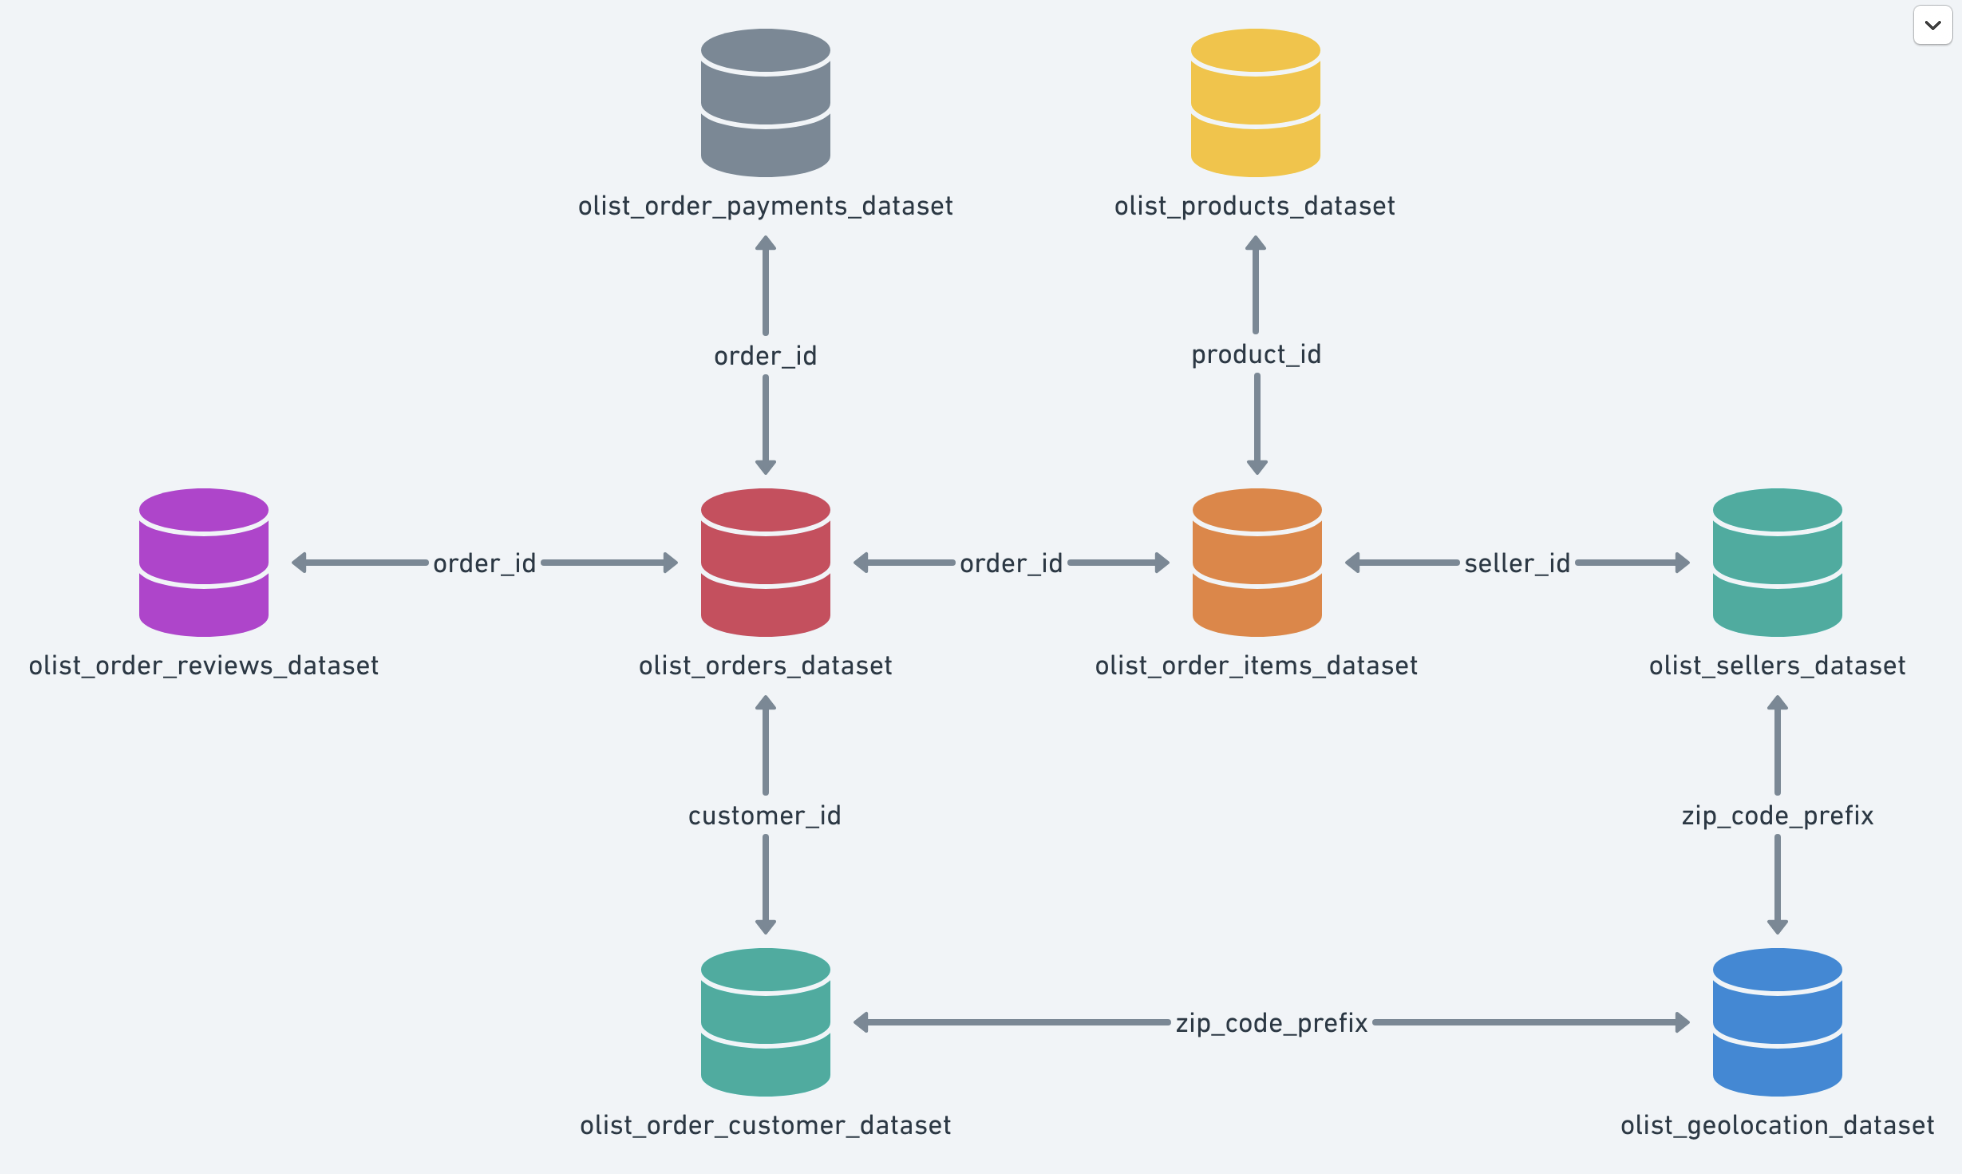

In [5]:
Image("data_tables.png")
#Overview of the different data tables:

### Data mapping: 

The information essentially needed, is a tables with customer ID's in rows and products in the columns, with reviews as values in the dataframe. This means that the three, customers, reviews and products are matched using order and order items respectively. 

Short overview of the relevant tables:

In [6]:
#df_orders.head()

In [7]:
#df_reviews.head()

In [8]:
#df_customer.head()

In [9]:
#df_products.head()

In [10]:
#df_items.head()

##### 1. Matching product ID's and product categories on the order items

In [11]:
df_items.describe(include="O")

,order_id,product_id,seller_id,shipping_limit_date
count,112650,112650,112650,112650
unique,98666,32951,3095,93318
top,8272b63d03f5f79c56e9e4120aec44ef,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,2017-07-21 18:25:23
freq,21,527,2033,21


In [12]:
print(len(df_items))

112650


In [13]:
df_products.describe(include="O")

,product_id,product_category_name
count,32951,32341
unique,32951,73
top,55610b8b7d48294e69fc23f513dfbe98,cama_mesa_banho
freq,1,3029


As seen, we have some duplicates of orderID's, since the customers who are ordering several products in one order, has different `order_item_id`. Thus at first, the table df_items is enriched with the `product_id` and `product_category_name` for every item. 

In [14]:
#Matching items and products to obtain the product category name:
ordered_products = df_items.merge(df_products, on="product_id", how= "left")

In [15]:
#Exclude irrelevant columns:
cols= ordered_products.columns
ordered_products = ordered_products[cols[0:8]]
ordered_products = ordered_products.drop(["shipping_limit_date", "price", "freight_value"], axis=1)

In [16]:
ordered_products.head()

,order_id,order_item_id,product_id,seller_id,product_category_name
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,moveis_decoracao
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,perfumaria
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,ferramentas_jardim


In [17]:
ordered_products.describe(include="O")

,order_id,product_id,seller_id,product_category_name
count,112650,112650,112650,111047
unique,98666,32951,3095,73
top,8272b63d03f5f79c56e9e4120aec44ef,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,cama_mesa_banho
freq,21,527,2033,11115


##### 2. Matching the unique customer ID's with the orders

In [18]:
df_customer.describe(include="O")

,customer_id,customer_unique_id,customer_city,customer_state
count,99441,99441,99441,99441
unique,99441,96096,4119,27
top,6fbdcb5b4167b52374230ce08df932d5,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP
freq,1,17,15540,41746


In [19]:
df_orders.describe(include="O")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,1b1f5c0333fae3e7b4b4670d2cc3c0ac,7ecbbee802d80c24f32bf5945c1ea36e,delivered,2018-06-01 13:39:44,2018-02-27 04:31:10,2018-05-09 15:48:00,2017-12-02 00:26:45,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522


In [20]:
print("Lenth of orders: ", len(df_orders), "Length of customers: ", len(df_customer))

Lenth of orders:  99441 Length of customers:  99441


As seen from the tables, there are less `customer_unique_id` than `customer_id`, which indicates that some customers has several `customer_id`'s. The unique customer ID's are now matched with all the `order_id`'s, such that every unique customers orders can be reviewd

In [21]:
# Unique customer ID's is matched witht the given order. The key is customer_id
unique_customer_orders = df_orders.merge(df_customer, on="customer_id", how= "left")

In [22]:
#And then we are only taking relevant columns:
cols = list(unique_customer_orders.columns[0:2])
cols.append("customer_unique_id")
unique_customer_orders = unique_customer_orders[cols]

In [23]:
unique_customer_orders.head()

,order_id,customer_id,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6


In [24]:
unique_customer_orders.describe(include="O")

,order_id,customer_id,customer_unique_id
count,99441,99441,99441
unique,99441,99441,96096
top,1b1f5c0333fae3e7b4b4670d2cc3c0ac,7ecbbee802d80c24f32bf5945c1ea36e,8d50f5eadf50201ccdcedfb9e2ac8455
freq,1,1,17


##### 3. The task is now to match the reviews on to every order. 

Short description of the review data:

In [25]:
df_reviews.describe(include="O")

,review_id,order_id,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
count,100000,100000,11715,41753,100000,100000
unique,99173,99441,4600,36921,637,99010
top,0c76e7a547a531e7bf9f0b99cba071c1,03c939fd7fd3b38f8485a0f95798f1f6,Recomendo,Muito bom,2017-12-19 00:00:00,2017-06-15 23:21:05
freq,3,3,426,230,466,4


As seen above, some order_id's have multiple reviews. Looking at one of the order_id's with three reviews, we see the following data-points:

In [26]:
df_reviews[df_reviews.order_id=='8e17072ec97ce29f0e1f111e598b0c85']

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
45043,67c2557eb0bd72e3ece1e03477c9dff5,8e17072ec97ce29f0e1f111e598b0c85,1,NaN,Entregou o produto errado.,2018-04-07 00:00:00,2018-04-08 22:48:27
65024,2d6ac45f859465b5c185274a1c929637,8e17072ec97ce29f0e1f111e598b0c85,1,NaN,Comprei 3 unidades do produto vieram 2 unidade...,2018-04-07 00:00:00,2018-04-07 21:13:05
93027,6e4c4086d9611ae4cc0cc65a262751fe,8e17072ec97ce29f0e1f111e598b0c85,1,NaN,"Embora tenha entregue dentro do prazo, não env...",2018-04-14 00:00:00,2018-04-16 11:37:31


We have to filter these duplicate values out, such that we do not have several reviews for each order. The reason why this might be, is that one order_id can have several items. However, it is not possible to link the different review_id's to the order_item_id, which means that we have to use assumptions. 

The approach is to use the aggregate mean for each order_id to calculate the score for that particular order. This might give the best result for the entire order and the different items in that order.

The review table looks like the following

In [27]:
df_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [28]:
len(df_reviews)

100000

In [29]:
reviews = df_reviews.groupby("order_id").mean().reset_index()

In [30]:
reviews.head()

,order_id,review_score
0,00010242fe8c5a6d1ba2dd792cb16214,5.0
1,00018f77f2f0320c557190d7a144bdd3,4.0
2,000229ec398224ef6ca0657da4fc703e,5.0
3,00024acbcdf0a6daa1e931b038114c75,4.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,5.0


And we can now match these reviews to every order. 

In [31]:
unique_orders = unique_customer_orders.merge(reviews, on="order_id", how="left")

In [32]:
unique_orders.head()

,order_id,customer_id,customer_unique_id,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,4.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,5.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,5.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,5.0


##### 4. Lastly, the two datasets with orders and items can now be combined. 

It is then assumed, that each item in an order is reviewed as the mean score for that particular order. This is an assumption which is mentioned in step 3. The all the reviews are therefore merged in to all the items, such that we get a per-item review score for each unique customer.

In [33]:
len(ordered_products)

112650

In [34]:
len(unique_orders)

99441

In [35]:
unique_orders.head()

,order_id,customer_id,customer_unique_id,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,4.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,5.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,5.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,5.0


In [36]:
ordered_products.head()

,order_id,order_item_id,product_id,seller_id,product_category_name
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,moveis_decoracao
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,perfumaria
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,ferramentas_jardim


In [37]:
item_review = ordered_products.merge(unique_orders, on="order_id", how="left")

In [38]:
item_review.head()

,order_id,order_item_id,product_id,seller_id,product_category_name,customer_id,customer_unique_id,review_score
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,cool_stuff,3ce436f183e68e07877b285a838db11a,871766c5855e863f6eccc05f988b23cb,5.0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,pet_shop,f6dd3ec061db4e3987629fe6b26e5cce,eb28e67c4c0b83846050ddfb8a35d051,4.0
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,moveis_decoracao,6489ae5e4333f3693df5ad4372dab6d3,3818d81c6709e39d06b2738a8d3a2474,5.0
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,perfumaria,d4eb9395c8c0431ee92fce09860c5a06,af861d436cfc08b2c2ddefd0ba074622,4.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,ferramentas_jardim,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,5.0


### Creating the final data-table

From the above item_review table, it is possible to make a table including per-customer and per-item reviews. However, a problem arise when trying to make a custumer-item-review table, since there are 32,951 unique products and 95,420 unique customers, which is too large to hold in memeory. Therefore, the number of purchases per product is sorted, and the products which has very few purchases are excluded. Arguably, these products might also be uncertain to recommend to others as they have not recieved a lot of reviews. 

In [39]:
len(item_review.product_id.unique())

32951

In [40]:
len(item_review.customer_unique_id.unique())

95420

In [41]:
len(item_review)

112650

In [42]:
#Creating a dataframe that will contain how many reviews each product has
pp = item_review.groupby("product_id")["review_score"].count().sort_values()
ppdf = pd.DataFrame(pp)
ppdf.head()

,review_score
product_id,
00066f42aeeb9f3007548bb9d3f33c38,1
911e26785862f450cf2240fc5168f83d,1
911cfb37438b7fa9ad54535990178868,1
911b8d269dbaa6c005b23d04e1c7fcbc,1
9117307cf75efa6e964d697f0d1297f9,1


In [43]:
#Creating a dataframe which only contain products that has more than 1 review 
ppdf_small = ppdf[ppdf.review_score>10]
len(ppdf_small)

1668

In [44]:
#Filtering the products with only 1 review out if the main dataframe
products = list(ppdf_small.index)
item_review_s = item_review[item_review['product_id'].isin(products)]
len(item_review_s)

47676

In [45]:
item_review_s.head()

,order_id,order_item_id,product_id,seller_id,product_category_name,customer_id,customer_unique_id,review_score
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,ferramentas_jardim,58dbd0b2d70206bf40e62cd34e84d795,64b576fb70d441e8f1b2d7d446e483c5,5.0
10,00061f2a7bc09da83e415a52dc8a4af1,1,d63c1011f49d98b976c352955b1c4bea,cc419e0650a3c5ba77189a1882b7556a,beleza_saude,c6fc061d86fab1e2b2eac259bac71a49,107e6259485efac66428a56f10801f4f,5.0
12,0006ec9db01a64e59a68b2c340bf65a7,1,99a4788cb24856965c36a24e339b6058,4a3ca9315b744ce9f8e9374361493884,cama_mesa_banho,5d178120c29c61748ea95bac23cb8f25,7ed0ea20347f67fe61d1c99fdf8556ae,5.0
13,0008288aa423d2a3f00fcb17cd7d8719,1,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,ferramentas_jardim,2355af7c75e7c98b43a87b2a7f210dc5,9e4159995424971423b98c4a8bc11529,5.0
14,0008288aa423d2a3f00fcb17cd7d8719,2,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,ferramentas_jardim,2355af7c75e7c98b43a87b2a7f210dc5,9e4159995424971423b98c4a8bc11529,5.0


Since some of the customers has bought the same products several times, these reviews has to be transformed in to one metric. Therefore, identical purchases from the same customer is averaged into one review score.

In [46]:
#Averaging identical purchases
item_review_ss = item_review_s.groupby(["customer_unique_id", "product_id"]).mean().reset_index()

In [47]:
#Creating a pivot table, which has unique customers in the rows, product id's in the columns and review score as
# values
dfr = item_review_ss.pivot(index= "customer_unique_id", columns= "product_id", values="review_score")
#dfr.shape

In [48]:
dfr.head()

product_id,001b72dfd63e9833e8c02742adf472e3,00250175f79f584c14ab5cecd80553cd,005030ef108f58b46b78116f754d8d38,00878d953636afec00d3e85d55a12e7f,008cff0e5792219fae03e570f980b330,00ba6d766f0b1d7b78a5ce3e1e033263,00baba5b58e274d0332a0c8a0a66f877,00de7f393d962717eeeb2d7131a40dba,013ee64977aaa6b2b25475095162e0e9,014a8a503291921f7b004a5215bb3c36,...,fe9dfbe7f974621789683b7b78be2a16,fecf6223a3494f35362f670e571d2a04,fed5c40c27e1c88560a9e92d82ee0825,ff29d8cb1cd0cd5ea37b80dac9939e1c,ff2c1ec09b1bb340e84f0d6b21cc7dbb,ff5f8606556b625613f069a5a9a48966,ff7fccf8513f360157f0660fe51d1d88,ffa7e0cbe11656d11a117b534bb1db27,ffaf0af7eebb57c7f262b51ebb05dfd6,ffc9caf33e2d1e9f44e3e06da19085f7
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00053a61a98854899e70ed204dd4bafe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0005e1862207bf6ccc02e4228effd9a0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0005ef4cd20d2893f0d9fbd94d3c0d97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0006fdc98a402fceb4eb0ee528f6a8d4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Item-item based collaborative filtering

At first, we start out simple using an item-item system, where we can recommend different users products, that they have not consumed yet. Lets look at the top 10 products to recommend the first user in our dataset. 

In [49]:
#Recommending top ten products that fits best to the first customer in the dataset
customer = list(dfr.index)[0]
products = 10

In [ ]:
#Calculating the correlation for between each item
correlations = dfr.corr()

In [ ]:
#Finding products that the customer has not yet purchased
_purchased = dfr.loc[customer]
_purchased = _purchased[_purchased.isnull()]
_purchased.head()

In [ ]:
for product, review in _purchased.iteritems():
    rating = 0
    weights_sum = 0
    neighbours_corr = correlations[product].sort_values(ascending=False)[1: products+1]
    item_mean = dfr[product].mean()
    neighbours_ratings = dfr[neighbours_corr.index].transpose()
    neighbours_means = neighbours_ratings.mean(axis=1)
    for neighbour_id, row in neighbours_ratings.iterrows():
        if np.isnan(row[customer]): continue
        rating += neighbours_corr[neighbour_id] * (row[customer] - neighbours_means[neighbour_id])
        weights_sum += abs(neighbours_corr[neighbour_id])
    if weights_sum > 0:
        rating /= weights_sum
    rating += item_mean
    _purchased.at[product] = rating

In [ ]:
#Top 10 recommended products for the customer 
_purchased.sort_values(ascending=False)[0:products]

It is also possible to look at what product category we are recommending the user, which is gives some more context to the prediction. 

In [ ]:
rec_cat = item_review_s[item_review_s["product_id"].isin(list(pd.DataFrame(_purchased.sort_values(ascending=False)\
                        [0:products]).index))].product_category_name.unique()

In [ ]:
#Displaying recommended categories:
list(rec_cat)

Apparently, some of the products is within the same product category, since we only get eight different categories. 

### SVD 

Since an item-item based collaborative filtering approach is relatively simple we are building a more complex model using an SVD

In [50]:
#Sorting out the data needed
data = item_review_s[["customer_unique_id","product_id", "review_score"]]

In [51]:
data.head()

,customer_unique_id,product_id,review_score
4,64b576fb70d441e8f1b2d7d446e483c5,ac6c3623068f30de03045865e4e10089,5.0
10,107e6259485efac66428a56f10801f4f,d63c1011f49d98b976c352955b1c4bea,5.0
12,7ed0ea20347f67fe61d1c99fdf8556ae,99a4788cb24856965c36a24e339b6058,5.0
13,9e4159995424971423b98c4a8bc11529,368c6c730842d78016ad823897a372db,5.0
14,9e4159995424971423b98c4a8bc11529,368c6c730842d78016ad823897a372db,5.0


In [52]:
print("The shape of the dataframe is: ", data.shape, " and the data includes", \
      len(data.groupby(["customer_unique_id"]).count()), " unique customers")

The shape of the dataframe is:  (47676, 3)  and the data includes 41425  unique customers


As we have so many unique customers we will take a small subset, and only look at the customers who has made at least two purchases. This will dramatically reduce the size of the dataset, but it will also make the predictions of higher quality, as we will have more data on each customer. 

In [53]:
#Creating a dataframe that will contain how many reviews each product has
pp = data.groupby("customer_unique_id")["product_id"].count().sort_values()
ppdf = pd.DataFrame(pp)
ppdf.head()

,product_id
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,1
a6abe15d926391d0b739f4f60ae20b43,1
a6ac029c3ae532651dc2591ebaaac6a6,1
a6ac32321c28c66770ea4629366ff27f,1
a6ae95cd207c7cb963b4b6e444434bfb,1


In [54]:
#Creating a dataframe which only contain products that has more than 1 review 
ppdf_small = ppdf[ppdf.product_id>3]
len(ppdf_small)

410

In [55]:
#Filtering the products with only 1 review out if the main dataframe
products = list(ppdf_small.index)
data = data[data['customer_unique_id'].isin(products)]
len(data)

2154

In [56]:
data.shape

(2154, 3)

In [57]:
data = data.reset_index()
data = data.drop(["index"],axis=1)

Then we can split the data into test and training data:

In [58]:
#Splitting the data into test/train by a 70% split
train_ind, test_ind = [], []
#
for i, product_id in enumerate(data['product_id'].unique()):
    rows = data[data['product_id'] == product_id]
#    print(rows)
    ind = rows.index[:2].values.tolist()
#    print(ind)
    train_ind += ind

#
c = 0.7
b = len(train_ind) / len(data)
a = (c - b) / (1 - b)
print(a)

0.586034593209481


In [59]:
all_ind = set(range(len(data)))
not_used = list(all_ind - set(train_ind))

In [60]:
not_done = True
np.random.seed(42)
while not_done:
    np.random.shuffle(not_used)
    train_ind_ = train_ind + not_used[:int(a * len(not_used))]
    df_train = data.loc[train_ind_]
    print(data.nunique()['product_id'], df_train.nunique()['product_id'])
    print(data.nunique()['customer_unique_id'], df_train.nunique()['customer_unique_id'])
    if data.nunique()['product_id'] == df_train.nunique()['product_id'] and data.nunique()['customer_unique_id'] == df_train.nunique()['customer_unique_id']:
        not_done = False
        train_ind = train_ind_

test_ind = list(all_ind - set(train_ind))
train_ind = sorted(train_ind)
test_ind = sorted(test_ind)
print(len(train_ind)/len(all_ind))
print(len(test_ind)/len(all_ind))

319 319
410 407
319 319
410 405
319 319
410 407
319 319
410 410
0.6996285979572887
0.30037140204271123


In [63]:
#Since the code above takes quite a while, the is saved for future runs
#np.savetxt('data/recommender_data_train.csv', train_ind, fmt="%d")
#np.savetxt('data/recommender_data_test.csv', test_ind, fmt="%d")

#if we want to load the data later
#train_ind = np.loadtxt('data/data_train.csv', dtype=int)
#test_ind = np.loadtxt('data/data_test.csv', dtype=int)

In [64]:
#Defining the train and test data from the split made above
df_train = data.iloc[train_ind]
df_test = data.iloc[test_ind]

In [65]:
#Defining helper functions to calculate RMSE and create a boxplot for later exploraiton of the precision of the model
def RMSE(y_true, y_pred):
    return np.linalg.norm(y_true - y_pred) / np.sqrt(len(y_true))

def MakeBoxplot(y_true, y_pred, title):
    data = [y_pred[y_true == (x*0.5+0.5)] for x in range(10)]
    fig = plt.figure(figsize=(5, 5))
    plt.boxplot(data)
    min_a, max_a = 0., 5.5
    plt.xlim((min_a, max_a))
    plt.ylim((min_a, max_a))
    plt.plot([min_a, max_a * 2], [min_a, max_a], ls='--', color='gray', linewidth=1.0)
    plt.xticks(range(12), [x*0.5 for x in range(12)])
    plt.xlabel('True Rating')
    plt.ylabel('Predicted Rating')
    plt.title(title)
    plt.show()

In [66]:
#Defining y_true from the test data
y_true = df_test['review_score'].values

##### Dummy baseline 

As a start, we are creating a dummy baseline, which are predicting the mean of all the reviews as a prediction for every review unknown to the model.

In [67]:
#Using the global mean of all the training reviews as prediction for the unknown test datapoints. 
global_mean = df_train['review_score'].mean()
print("global_mean =", global_mean)

global_mean = 3.340743198407432


In [68]:
#Using the variable global_mean as prediction
y_pred = []
for i, row in df_test.iterrows():
    y_pred.append(global_mean)
y_pred = np.array(y_pred)

RMSE = 1.6662206994211866


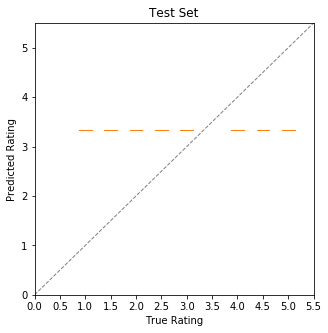

In [69]:
#Calculating the performance of the model
error = RMSE(y_true, y_pred)
print("RMSE =", error)
MakeBoxplot(y_true, y_pred, 'Test Set')

##### Beating the baseline model

As the average review for all products might be a bad estimate for how a given customer might rate some product, we will try to beat this baseline. For this purpose, an SVD model is implemented to predict ratings of unrated products for customers. This will hopefully beat the baseline model but also the item-item based collaborative filtering model. However, results from the SVD can not be directly compared to the predictions of the item-item based recommendation system, as we did not split values into test/train values. 

In [70]:
#Defining the rating scale (from 0.5 to 5) and loading our dataset from a pandas dataframe. 
reader = Reader(rating_scale=(0.5, 5.0))
data_surprise = Dataset.load_from_df(df_train, reader)

In [71]:
#Using grid search to tune the hyperparameters of the model. Note also, that we are using 5 cross validations. 
param_grid = {
    'n_epochs': [5, 10, 20], 
    'lr_all': [0.005, 0.05, 0.01],
    'reg_all': [0.001, 0.01, 0.1], 
    'n_factors': [10, 25, 50, 100],
    'biased': [True, False]
}

#Creating the grid and conducting grid-search
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
gs.fit(data_surprise)

#Printing the best RMSE score and the best hyperparameters: 
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.5746480275858245
{'n_epochs': 20, 'lr_all': 0.05, 'reg_all': 0.01, 'n_factors': 25, 'biased': True}


In [72]:
#We define the model, as the one having the bese RMSE
model = gs.best_estimator['rmse']
model.fit(data_surprise.build_full_trainset());

In [73]:
#Defining the test values for customer and product ID's
customer_ids_true = df_test['customer_unique_id'].values
product_ids_true = df_test['product_id'].values

In [74]:
#Predicting customer values: 
y_pred = []
for customer_id, product_id in zip(customer_ids_true, product_ids_true):
    r = model.predict(customer_id, product_id, verbose=False).est
    y_pred.append(r)
y_pred = np.array(y_pred)
# performance


In [75]:
y_true

array([1. , 4. , 3. , 4. , 4. , 4. , 4. , 4. , 5. , 5. , 5. , 5. , 5. ,
       3. , 5. , 5. , 5. , 1. , 3. , 3. , 3. , 4. , 4. , 4. , 5. , 1. ,
       1. , 2. , 2. , 5. , 3. , 5. , 4. , 5. , 5. , 5. , 4. , 4. , 4. ,
       4. , 4. , 4. , 4. , 4. , 1. , 1. , 1. , 1. , 1. , 1. , 2. , 5. ,
       1. , 1. , 1. , 1. , 5. , 5. , 3. , 3. , 5. , 5. , 1. , 1. , 5. ,
       5. , 4. , 3. , 3. , 1. , 1. , 2. , 2. , 1. , 1. , 2. , 3. , 3. ,
       3. , 3. , 5. , 5. , 1. , 5. , 5. , 4. , 4. , 4. , 2. , 1. , 1. ,
       1. , 1. , 1. , 4. , 4. , 4. , 3. , 3. , 5. , 5. , 5. , 5. , 5. ,
       5. , 4. , 4. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5. ,
       5. , 5. , 1. , 5. , 1. , 1. , 4. , 4. , 1. , 5. , 1. , 3. , 3. ,
       3. , 3. , 3. , 3. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 4. ,
       4. , 4. , 5. , 5. , 3. , 3. , 3. , 3. , 2.5, 3. , 3. , 4. , 4. ,
       4. , 2. , 2. , 1. , 1. , 1. , 5. , 5. , 1. , 1. , 1. , 5. , 5. ,
       5. , 5. , 1. , 1. , 5. , 5. , 5. , 5. , 5. , 5. , 5. , 5.

In [76]:
len(y_pred)

647

RMSE = 0.5010094361727017


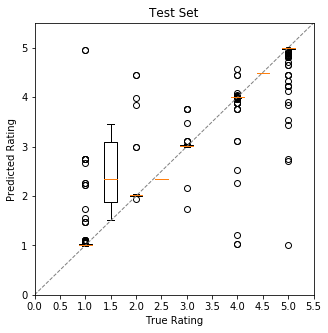

In [77]:
error = RMSE(y_true, y_pred)
print("RMSE =", error)
MakeBoxplot(y_true, y_pred, 'Test Set')

### Trying to beat the SVD with a deep learning model

#https://medium.com/@jdwittenauer/deep-learning-with-keras-recommender-systems-e7b99cb29929

In [78]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [79]:
#data = item_review_s[["customer_unique_id","product_id", "review_score"]]

In [80]:
data.shape

(2154, 3)

In [81]:
data.columns = ["userId", "movieId", "rating"]

In [82]:
data.head()

,userId,movieId,rating
0,35ecdf6858edc6427223b64804cf028e,e8c6039a25765995ac7c1ec2cbef5765,5.0
1,ec4d3f58a02a9b6a80fdf59418416b5f,2fd91ba79b5f4f8342b67bd79cb54b3f,4.0
2,ec4d3f58a02a9b6a80fdf59418416b5f,2fd91ba79b5f4f8342b67bd79cb54b3f,4.0
3,ec4d3f58a02a9b6a80fdf59418416b5f,2fd91ba79b5f4f8342b67bd79cb54b3f,4.0
4,ec4d3f58a02a9b6a80fdf59418416b5f,2fd91ba79b5f4f8342b67bd79cb54b3f,4.0


In [83]:
ratings = data

In [ ]:
g = ratings.groupby('userId')['rating'].count()
top_users = g.sort_values(ascending=False)[:15]
g = ratings.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False)[:15]
top_r = ratings.join(top_users, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(top_movies, rsuffix='_r', how='inner', on='movieId')
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

In [ ]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
n_users = ratings['user'].nunique()
item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movieId'].values)
n_movies = ratings['movie'].nunique()
ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])
print("Number of customers, products, their min rating and max rating: ", n_users, n_movies, min_rating, max_rating)

In [ ]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
n_factors = 50
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [ ]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam, RMSprop
from keras.regularizers import l2

In [ ]:
def RecommenderV1(n_users, n_movies, n_factors):
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((n_factors,))(u)
    
    movie = Input(shape=(1,))
    m = Embedding(n_movies, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Reshape((n_factors,))(m)
    
    x = Dot(axes=1)([u, m])
    model = Model(inputs=[user, movie], outputs=x)
    #opt = Adam(lr=0.05,beta_1=0.001)
    opt = RMSprop(lr=0.001, rho= 0.9)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [ ]:
model = RecommenderV1(n_users, n_movies, n_factors)
model.summary()

In [ ]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=15,
                    verbose=1, validation_data=(X_test_array, y_test))

In [ ]:
history.history["loss"][-1]

##### Trying an even more advanced model:

In [ ]:
from keras import backend as K

In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [ ]:
from keras.layers import Add, Activation, Lambda
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x
def RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    mb = EmbeddingLayer(n_movies, 1)(movie)
    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss=root_mean_squared_error, optimizer=opt)#, metrics=['mse'])
    return model

In [ ]:
model = RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()

In [ ]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=15,
                    verbose=1, validation_data=(X_test_array, y_test))

In [ ]:
print("The RMSE of the deep learning model is therefore: ", history.history["loss"][-1])